# <center>CSE 4/574: Introduction to Machine Learning</center>
## <center>Prof. Sargur Srihari</center>
### <center>Assignment 3</center>

In [ ]:
# Imports
import gym
from gym import spaces
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Stock Trading Environment 

In [ ]:
# Defining the Stock Trading Environment.
"""DON'T MAKE ANY CHANGES TO THE ENVIRONMENT."""


class StockTradingEnvironment(gym.Env):
    """This class implements the Stock Trading environment."""

    def __init__(self, file_path, train=True, number_of_days_to_consider=10):
        """This method initializes the environment.

        :param file_path: - Path of the CSV file containing the historical stock data.
        :param train: - Boolean indicating whether the goal is to train or test the performance of the agent.
        :param number_of_days_to_consider = Integer representing whether the number of days the for which the agent
                considers the trend in stock price to make a decision."""

        self.file_path = file_path  # Path of the CSV file containing the historical stock data.
        self.stock_data = pd.read_csv(self.file_path)  # Reading the CSV file containing the historical stock data.
        self.train = train  # Boolean indicating to use the training stock data by default.
        # Splitting the data into train and test datasets.
        self.training_stock_data = self.stock_data.iloc[:int(0.8 * len(self.stock_data))]
        self.testing_stock_data = self.stock_data.iloc[int(0.8 * len(self.stock_data)):].reset_index()
        self.observation_space = spaces.Discrete(4)  # This defines that there are four states in the environment.
        # This defines that there are 3 discrete actions that the agent can perform (Buy, Sell, Hold).
        self.action_space = spaces.Discrete(3)
        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # This defines the number of days for which the agent considers the data before taking an action.
        self.number_of_days_to_consider = number_of_days_to_consider
        # The maximum timesteps the agent will take before the episode ends.
        if self.train:
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider
        else:
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider
        # Initializing the number of steps taken to 0.
        self.timestep = 0
        self.reset()

    def reset(self):
        """This method resets the environment and returns the observation.

        :returns observation: - (Integer in the range of 0 to 3 representing the four possible observations that the
                                 agent can receive. The observation depends upon whether the price increased on average
                                 in the number of days the agent considers, and whether the agent already has the stock
                                 or not.)"""

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # Initializing the number of steps taken to 0.
        self.timestep = 0

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = 1
                price_decrease = 0
            else:
                price_increase = 0
                price_decrease = 1

            # Observation vector that will be passed to the agent.
            observation = [price_increase, price_decrease, 0, 1]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = 1
                price_decrease = 0
            else:
                price_increase = 0
                price_decrease = 1

            # Observation vector.
            observation = [price_increase, price_decrease, 0, 1]
        if np.array_equal(observation, [1, 0, 0, 1]):
            observation = 0
        if np.array_equal(observation, [1, 0, 1, 0]):
            observation = 1
        if np.array_equal(observation, [0, 1, 0, 1]):
            observation = 2
        if np.array_equal(observation, [0, 1, 1, 0]):
            observation = 3

        return observation

    def step(self, action):
        """This method implements what happens when the agent takes the action to Buy/Sell/Hold.

        :param action: - (Integer in the range 0 to 2 inclusive.)

        :returns observation: - (Integer in the range of 0 to 3 representing the four possible observations that the
                                 agent can receive. The observation depends upon whether the price increased on average
                                 in the number of days the agent considers, and whether the agent already has the stock
                                 or not.)
                 reward: - (Integer/Float value that's used to measure the performance of the agent.)
                 done: - (Boolean describing whether or not the episode has ended.)
                 info: - (A dictionary that can be used to provide additional implementation information.)"""

        # We give the agent a penalty for taking actions such as buying a stock when the agent doesn't have the
        # investment capital and selling a stock when the agent doesn't have any shares.
        penalty = 0

        if self.train:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.training_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value +=\
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider]\
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        else:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.testing_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = self.training_stock_data['Open'][
                                           self.timestep + self.number_of_days_to_consider] * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        # Determining if the agent currently has shares of the stock or not.
        if self.number_of_shares > 0:
            stock_held = 1
            stock_not_held = 0
        else:
            stock_held = 0
            stock_not_held = 1

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = 1
                price_decrease = 0
            else:
                price_increase = 0
                price_decrease = 1

            # Observation vector.
            observation = [price_increase, price_decrease, stock_held, stock_not_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = 1
                price_decrease = 0
            else:
                price_increase = 0
                price_decrease = 1

            # Observation vector.
            observation = [price_increase, price_decrease, stock_held, stock_not_held]

        self.timestep += 1  # Increasing the number of steps taken by the agent by 1.

        if np.array_equal(observation, [1, 0, 0, 1]):
            observation = 0
        if np.array_equal(observation, [1, 0, 1, 0]):
            observation = 1
        if np.array_equal(observation, [0, 1, 0, 1]):
            observation = 2
        if np.array_equal(observation, [0, 1, 1, 0]):
            observation = 3

        # Computing the total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # Appending the total account value of the list to plot the graph.
        self.total_account_value_list.append(self.total_account_value)

        # The episode terminates when the number of infected people becomes greater than 75 % of the population.
        done = True if (self.timestep >= self.max_timesteps) \
            else False

        info = {}
        return observation, reward, done, info

    def render(self, mode='human'):
        """This method renders the agent's total account value over time.

        :param mode: 'human' renders to the current display or terminal and returns nothing."""

        plt.figure(figsize=(15, 10))
        plt.plot(self.total_account_value_list, color='lightseagreen', linewidth=7)
        plt.xlabel('Days', fontsize=32)
        plt.ylabel('Total Account Value', fontsize=32)
        plt.title('Total Account Value over Time', fontsize=38)
        plt.grid()
        plt.show()

### TO DO: Implement the Q-learning algorithm 

In [ ]:
stock_trading_environment = StockTradingEnvironment('./NVDA.csv', number_of_days_to_consider=10)

**Create the Q-table and initialize it**

In [ ]:
q_table_action_size = stock_trading_environment.action_space.n
q_table_state_size = stock_trading_environment.observation_space.n

print(f"Size of Action Space : {q_table_action_size} | Size of State Space: {q_table_state_size}")

Size of Action Space : 3 | Size of State Space: 4


In [ ]:
q_table = np.zeros((q_table_state_size, q_table_action_size))
print(q_table)
print("q-table shape: ", q_table.shape)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
q-table shape:  (4, 3)


**Q-learning algorithm**

•	The goal of the agent is to increase the total rewards it will obtain from the environment. This function to maximize is known as discounted return function which is given as G.

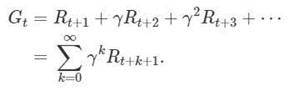

•	For maximizing the rewards, the agent needs to find an optimal policy and this Optimal policy is given by Bellman Optimality Equation.
 
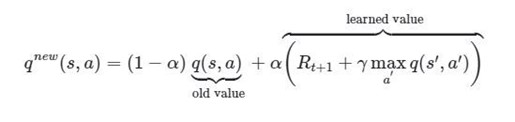

Here Q is Action-Value function or Q-value function

•	α (Alpha) in the equation is the learning rate which controls convergence. It also determines how our Q-values are updated.


In [ ]:
# Implementing Q-Learning for the stock trading environment.
class QLearning:
    """This class implements the Q-learning algorithm."""

    def __init__(self, environment):
        self.environment = environment

        # Parameters for Exploration
        self.epsilon = 1.0                     # Exploration rate parameter
        self.maximum_epsilon = 1.0             # Exploration probability which is at Maximum at start
        self.minimum_epsilon = 0.01            # Minimum exploration probability
        self.rate_of_decay = 0.005             # Rate of Decay for Exploration

        # Hyperparameters
        self.episodes_total = 2000             # Total number of episodes
        self.l_r = 0.05                        # Learning rate
        self.gamma = 0.90                      # Discounting rate        

        # Lists to store totals
        self.rewards = []                      # List of rewards
        self.episodes = []                     # List of Episodes
        self.total_rewards = 0                 # Total Rewards
        self.epsilon_decay_total = []          # Total Epsilon decay

    def train(self):
        """This method performs the agent training."""

        # List of rewards
        self.rewards = []
        self.episodes = []
        
        # Loop until training stops
        for ep in range(self.episodes_total):
            state = self.environment.reset()  # The environment is reset initially
            step = 0
            done = False
            self.total_rewards = 0
            
            while not done:  
                exploration_exploitation_rand = np.random.uniform(0, 1)  # We chose a random number between 0 and 1
                
                # if this random number is greater than epsilon, then we perform Exploitation
                # else we perform Exploration by performing a random action
                action = np.argmax(q_table[state,:]) if exploration_exploitation_rand > self.epsilon else self.environment.action_space.sample()

                # Perform the step function with above obtined action and store the outcomes as below
                new_state, reward, done, info = self.environment.step(action)

                # Update q_table using equation => Q(state,action):= (1 - learning_rate) * Q(state,action) + (learning_rate) * [Reward(state,action) + Discounting_rate * max Q(new state,new action) - Q(state,action)]
                q_table[state, action] = (1 - self.l_r) * q_table[state, action] + self.l_r * (reward + self.gamma * np.max(q_table[new_state, :]) - q_table[state, action])
                
                self.total_rewards += reward  # Rewards are added at each step and stored to total_rewards
                state = new_state             # The obtained new_state becomes the state
                
            # Epsilon decay for decreasing the exploration
            self.epsilon = self.minimum_epsilon + (self.maximum_epsilon - self.minimum_epsilon) * np.exp(-self.rate_of_decay * ep) 

            if (ep <= 800):
                self.epsilon_decay_total.append(self.epsilon)
                self.episodes.append(ep)
                self.rewards.append(self.total_rewards)

            if ep % 500 == 0:
                print("episode: ", ep)
                print("total episode reward : ",self.total_rewards)
            
        # self.environment.render(self)    # Renders the Total account value over time 
        print ("Rewards over time: " +  str(sum(self.rewards)/self.episodes_total))
        print("q-table after training : \n", q_table)
        print("Total Account value for train: ", self.environment.total_account_value)

    def evaluate(self):
        """This method evaluate the trained agent's performance."""

        """"TO DO: Evaluate the trained agent's performance by selecting only the greedy/best action in each state."""
        self.environment.train = False

        self.maximum_steps_per_episode = 150   # Max steps per episode

        # The environment is reset initially
        state = self.environment.reset()
        step = 0
        done = False
        self.total_rewards = 0
        
        while not done:  
            action = np.argmax(q_table[state,:])   # Here we perform only exploitation => we take the max from q_table as action
            new_state, reward, done, info = self.environment.step(action)   # Perform the step function with above obtined action and store the outcomes as below

            # Update q_table using equation => Q(state,action):= Q(state,action) + (learning_rate) * [Reward(state,action) + Discounting_rate * max Q(new state,new action) - Q(state,action)]
            q_table[state, action] = (1 - self.l_r) * q_table[state, action] + self.l_r * (reward + self.gamma * np.max(q_table[new_state, :]) - q_table[state, action])
            self.total_rewards += reward           # Rewards are added at each step and stored to total_rewards
            state = new_state                      # The obtained new_state becomes the state

        self.environment.render(self)              # Renders the Total account value over time
        print("q-table for evaluate : \n", q_table)
        print("Total Account value for evaluate : ", self.environment.total_account_value)

    def plot(self):
        """This method plots the reward dynamics and epsilon decay."""

        """TO DO: Plot the total reward per episode and epsilon decay when training."""
        # Episodes vs Total Reward
        plt.figure(figsize=(16, 8))
        plt.plot(self.episodes, self.rewards, color='lightseagreen', linewidth=2)
        plt.xlabel('Episodes', fontsize=15)
        plt.ylabel('Reward Value', fontsize=15)
        plt.title('Total Reward per Episode', fontsize=15)
        plt.grid()
        plt.show()

        # Episodes vs Epsilon decay
        plt.figure(figsize=(16, 8))
        plt.plot(self.episodes, self.epsilon_decay_total, color='lightseagreen', linewidth=2)
        plt.xlabel('Episodes', fontsize=15)
        plt.ylabel('Epsilon values', fontsize=15)
        plt.title('Epsilon Decay', fontsize=15)
        plt.grid()
        plt.show()


In [ ]:
output = QLearning(stock_trading_environment)

In [ ]:
# Total Account value before training
stock_trading_environment.total_account_value

100000

In [ ]:
output.train()

episode:  0
total episode reward :  -3233.2582371123585
episode:  500
total episode reward :  7189.074366456256
episode:  1000
total episode reward :  7148.353437294808
episode:  1500
total episode reward :  7408.55440281134
Rewards over time: 1655.6149198930352
q-table after training : 
 [[ 4.15777076 -3.13242718  0.67167151]
 [-0.67712549  4.22394987 12.12979895]
 [ 2.36212888 -3.92109784  0.64385297]
 [-3.22718472  2.5614617  -2.6421043 ]]
Total Account value for train:  844020.3820830005


In [ ]:
# Total Account value after training
print("Total Account value after training : ", stock_trading_environment.total_account_value)

Total Account value after training :  844020.3820830005


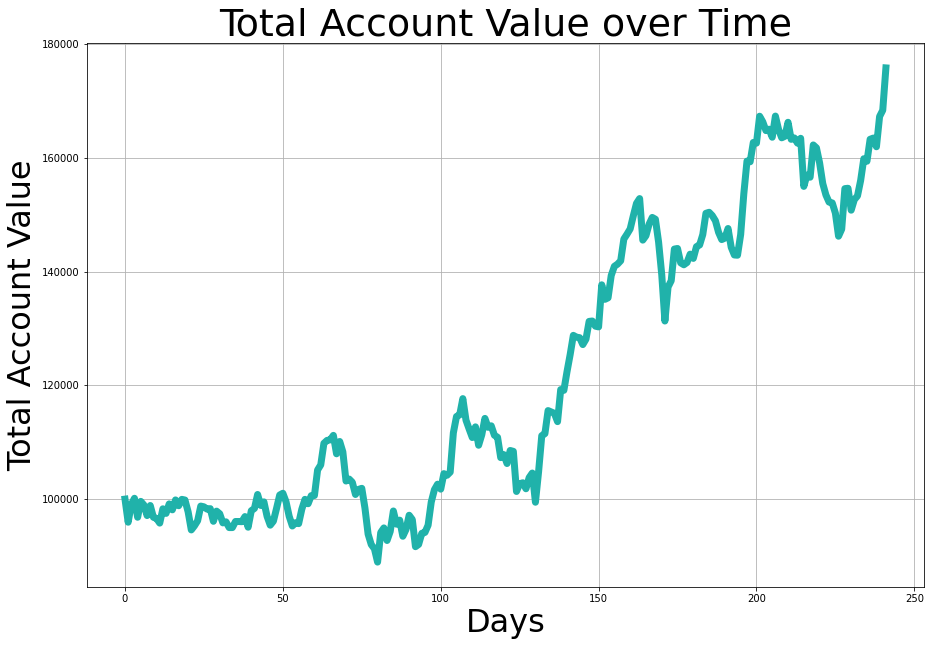

q-table for evaluate : 
 [[  4.54572317  -3.13242718   0.67167151]
 [ -0.67712549   4.22394987 185.97489542]
 [  2.04644604  -3.92109784   0.64385297]
 [ -3.22718472  -5.3169907   87.81703222]]
Total Account value for evaluate :  175852.10231000002


In [ ]:
# Evaluating the agent performance
output.evaluate()

In [ ]:
# Total Account value after evaluating
print("Total Account value after evaluating : ", stock_trading_environment.total_account_value)

Total Account value after evaluating :  175852.10231000002


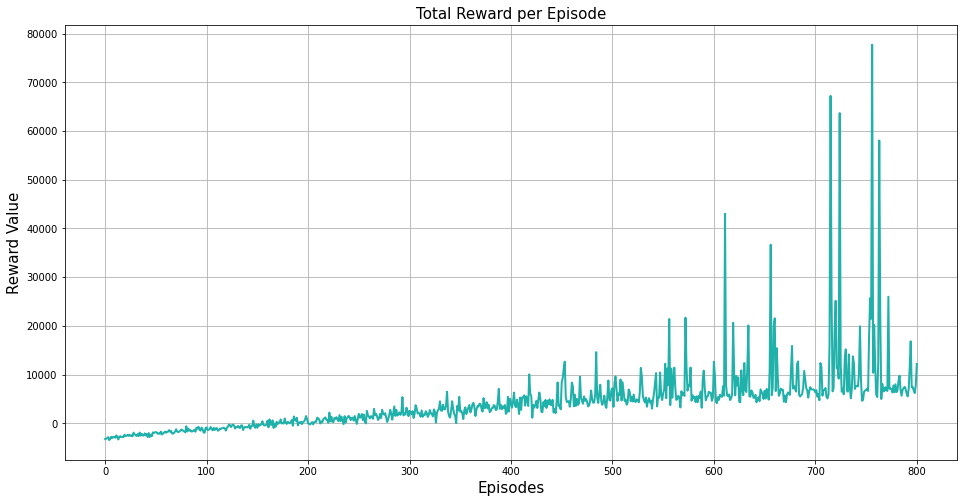

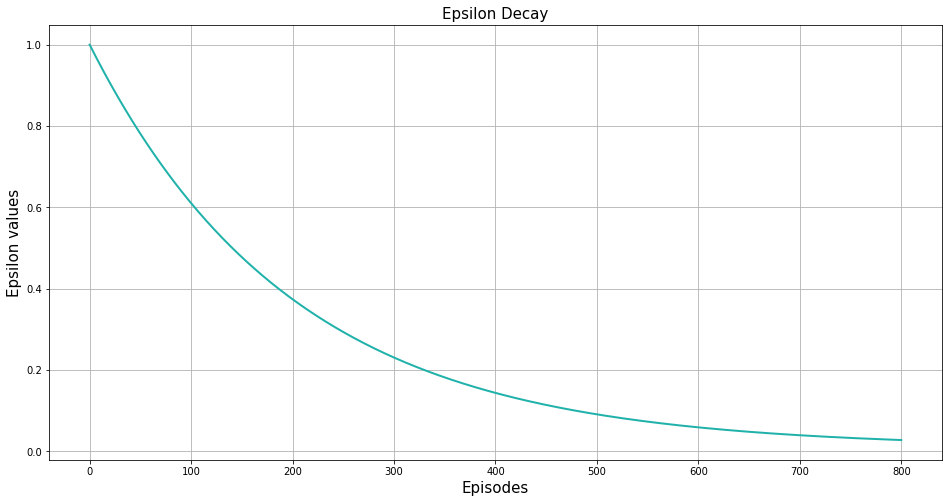

In [ ]:
# Plots
# Total Reward per Episode
# Epsilon Decay
output.plot()